In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [257]:
data = pd.read_csv('c:\\users\\mmingalov\\geekbrains-recommend-systems\\retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [258]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]
data_test

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2277416,338,41260573635,636,840173,1,1.99,369,0.00,112,92,0.0,0.0
2277417,338,41260573635,636,1037348,1,0.89,369,-0.30,112,92,0.0,0.0
2277418,338,41260573635,636,5592737,2,1.58,369,-0.20,112,92,0.0,0.0
2277419,338,41260573635,636,7441679,1,3.69,369,0.00,112,92,0.0,0.0
2277420,338,41260573635,636,7442317,1,2.69,369,0.00,112,92,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2396799,1613,41655820646,663,16102849,1,2.00,3262,-1.15,1231,95,0.0,0.0
2396800,1001,41655829421,663,13217063,1,1.69,3131,0.00,2231,95,0.0,0.0
2396801,1001,41655829421,663,13217800,1,1.69,3131,0.00,2231,95,0.0,0.0
2396802,1167,41656790510,663,6410462,22451,43.98,3385,-0.65,1059,95,0.0,0.0


### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [259]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    items = np.array(items_probabilities['item_id'])
    probability = np.array(items_probabilities['probability'])
    
    recs = np.random.choice(items, size=n, replace=False, p=probability)
    
    return recs.tolist()

In [260]:
%%time

data = data_train
items_probabilities = data.groupby('item_id')['sales_value'].sum().reset_index()

#комментарий преподавателя:
#как правило эта проблема решается через log(1 + x), в Numpy для этого есть специальная функция np.log1p()
#это также поможет обойти ситуацию с нулевыми продажами

items_probabilities['log'] = np.log1p(items_probabilities['sales_value'])
sum_ = items_probabilities.log.sum()

#probability -- это условная вероятность сэмплирования товара
items_probabilities['probability'] = items_probabilities['log']/sum_.sum()

#сумма по всем товарам д.б. равна единице, проверим
items_probabilities.probability.sum()

Wall time: 252 ms


1.0

In [261]:
weighted_random_recommendation(items_probabilities,5)

[975004, 986457, 12132699, 15574274, 874209]

### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [262]:
def typess(df):
    for j in range(df.shape[1]):
        print(type(df.iloc[0][j]))

In [263]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [264]:
#функция необходима для корректного парсинга CSV -- приводит значения к типу list
def String_to_List(result):
    for i in range(result.shape[0]):
        tt = 'actual'
        result[tt][i] = [int(x) for x in list(result[tt][i].replace('[','').replace(']','').split(', '))]
        tt = 'random_recommendation'
        result[tt][i] = [int(x) for x in list(result[tt][i].replace('[','').replace(']','').split(', '))]
        tt = 'popular_recommendation'
        result[tt][i] = [int(x) for x in list(result[tt][i].replace('[','').replace(']','').split(', '))]
        tt = 'itemitem'
        result[tt][i] = [int(x) for x in list(result[tt][i].replace('[','').replace(']','').split(', '))]
        tt = 'cosine'
        result[tt][i] = [int(x) for x in list(result[tt][i].replace('[','').replace(']','').split(', '))]
        tt = 'tfidf'
        result[tt][i] = [int(x) for x in list(result[tt][i].replace('[','').replace(']','').split(', '))]
        tt = 'own_purchases'
        result[tt][i] = [int(x) for x in list(result[tt][i].replace('[','').replace(']','').split(', '))]
    


In [289]:
result = pd.read_csv('c:\\users\\mmingalov\\geekbrains-recommend-systems\\predictions_basic.csv')

result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[888210, 9884308, 1163153, 9419753, 996833]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1078063, 881635, 6534085, 13511452, 6533350]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[999999, 1082185, 1098066, 6534178, 1127831]"


In [290]:
typess(result)

<class 'numpy.int64'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [291]:
#видим, что наши списки в CSV лежат в виде строковых значений. Запускаем обработку
String_to_List(result)

<ipython-input-264-503fc4cac26c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[tt][i] = [int(x) for x in list(result[tt][i].replace('[','').replace(']','').split(', '))]
<ipython-input-264-503fc4cac26c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[tt][i] = [int(x) for x in list(result[tt][i].replace('[','').replace(']','').split(', '))]
<ipython-input-264-503fc4cac26c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [292]:
#проверяем результат конвертации в тип данных lis
typess(result)

<class 'numpy.int64'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [293]:
#result['actual'][0]

In [294]:
result.apply(lambda row: precision_at_k(row['random_recommendation'], row['actual']), axis=1).mean()

0.0005876591576885406

In [295]:
result.apply(lambda row: precision_at_k(row['popular_recommendation'], row['actual']), axis=1).mean()

0.15523996082272082

In [296]:
result.apply(lambda row: precision_at_k(row['itemitem'], row['actual']), axis=1).mean()

0.15122428991184922

In [297]:
result.apply(lambda row: precision_at_k(row['cosine'], row['actual']), axis=1).mean()

0.15514201762977264

In [298]:
result.apply(lambda row: precision_at_k(row['tfidf'], row['actual']), axis=1).mean()

0.16092066601371002

In [299]:
result.apply(lambda row: precision_at_k(row['own_purchases'], row['actual']), axis=1).mean()

0.17969311132876015

### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ- {2000, 5000, 10000} товаров. Постройте график зависимости precision@5 от топ-*

In [321]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [300]:
data_train.shape[0], data_test.shape[0]

(2278490, 118314)

In [301]:
def random_recommendation(items, n):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()
def popularity_recommendation(data, n):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

def weighted_random_recommendation(items_probabilities, n):
    """Случайные рекоммендации
    
    Input
    -----
    items_probabilities: pd.DataFrame
        Датафрейм со столбцами item_id, probability. Сумма probability по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # посмотрите в документации параметр, отвечающий за вероятность сэмплирования
    # your_code

    items = np.array(items_probabilities['item_id'])
    probability = np.array(items_probabilities['probability'])
    
    recs = np.random.choice(items, size=n, replace=False, p=probability)
    
    return recs.tolist()



In [330]:
n_list=[2000,5000,10000]
for n in n_list:
    print('random_recommendation'+ str(n))

random_recommendation2000
random_recommendation5000
random_recommendation10000


In [331]:
#посчитамем BASELINES
for n in n_list:
    items = data_train.item_id.unique()
    result['random_recommendation'+ str(n)] = result['user_id'].apply(lambda x: random_recommendation(items, n))

    result['popular_recommendation'+ str(n)] = result['user_id'].apply(lambda x: popularity_recommendation(data_train, n))

    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    items_probabilities = data.groupby('item_id')['sales_value'].sum().reset_index()
    items_probabilities['log'] = np.log1p(items_probabilities['sales_value'])
    sum_ = items_probabilities.log.sum()
    #probability -- это условная вероятность сэмплирования товара
    items_probabilities['probability'] = items_probabilities['log']/sum_.sum()
    #сумма по всем товарам д.б. равна единице, проверим
    print(items_probabilities.probability.sum(), ' -- проверка на 1')
    result['weighted_random_recommendation'+ str(n)] = result['user_id'].apply(\
                                                            lambda x: weighted_random_recommendation(items_probabilities,n))

0.9999999999999999  -- проверка на 1
0.9999999999999999  -- проверка на 1
0.9999999999999999  -- проверка на 1


In [341]:
#добавим
result['weighted_random_recommendation'] = result['user_id'].apply(\
                                                            lambda x: weighted_random_recommendation(items_probabilities,5))

In [332]:
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,random_recommendation2000,popular_recommendation2000,weighted_random_recommendation2000,random_recommendation5000,popular_recommendation5000,weighted_random_recommendation5000,random_recommendation10000,popular_recommendation10000,weighted_random_recommendation10000
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[888210, 9884308, 1163153, 9419753, 996833]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[999999, 1082185, 1029743, 995785, 1004906]","[12428381, 10285345, 1873378, 10145099, 159257...","[6534178, 6533889, 1029743, 6534166, 1082185, ...","[1054019, 1095793, 845091, 938186, 2588096, 11...","[1673316, 1785252, 8090502, 1083552, 6442856, ...","[6534178, 6533889, 1029743, 6534166, 1082185, ...","[10126371, 15717274, 819266, 1074432, 230509, ...","[847006, 882716, 1102697, 15507552, 9655004, 1...","[6534178, 6533889, 1029743, 6534166, 1082185, ...","[923169, 1051501, 952539, 5996588, 819114, 953..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1078063, 881635, 6534085, 13511452, 6533350]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[999999, 1082185, 1098066, 6534178, 1127831]","[12604474, 12384779, 10311749, 5996276, 675778...","[6534178, 6533889, 1029743, 6534166, 1082185, ...","[1401978, 9483753, 893627, 955465, 10206904, 8...","[10285006, 1498801, 15552926, 13095511, 691930...","[6534178, 6533889, 1029743, 6534166, 1082185, ...","[917387, 1046545, 6534635, 1066639, 950899, 10...","[878442, 6022376, 10145807, 9881657, 9829976, ...","[6534178, 6533889, 1029743, 6534166, 1082185, ...","[860227, 1065089, 6396634, 13774849, 7168970, ..."


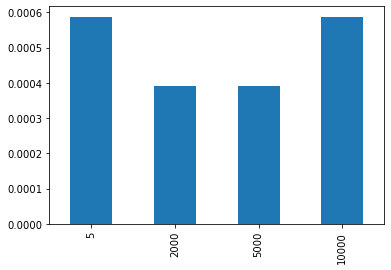

In [347]:
values_N = [
    result.apply(lambda row: precision_at_k(row['random_recommendation'], row['actual']), axis=1).mean()
    ,result.apply(lambda row: precision_at_k(row['random_recommendation2000'], row['actual']), axis=1).mean()
    ,result.apply(lambda row: precision_at_k(row['random_recommendation5000'], row['actual']), axis=1).mean()
    ,result.apply(lambda row: precision_at_k(row['random_recommendation10000'], row['actual']), axis=1).mean()
]
labels = [str(x) for x in [5]+(n_list)]

plt_data = pd.Series(values_N, index= labels)
plt_data.plot(kind="bar")

In [348]:
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']

fig = go.Figure(data=[go.Pie(labels=labels, values=values_N)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()


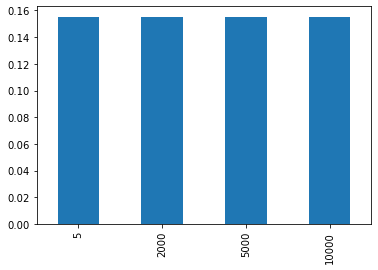

In [349]:
values_N = [
    result.apply(lambda row: precision_at_k(row['popular_recommendation'], row['actual']), axis=1).mean()
    ,result.apply(lambda row: precision_at_k(row['popular_recommendation2000'], row['actual']), axis=1).mean()
    ,result.apply(lambda row: precision_at_k(row['popular_recommendation5000'], row['actual']), axis=1).mean()
    ,result.apply(lambda row: precision_at_k(row['popular_recommendation10000'], row['actual']), axis=1).mean()
]
labels = [str(x) for x in [5]+(n_list)]

plt_data = pd.Series(values_N, index= labels)
plt_data.plot(kind="bar")

In [350]:
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']

fig = go.Figure(data=[go.Pie(labels=labels, values=values_N)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()


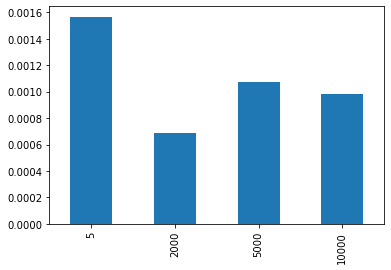

In [351]:
values_N = [
    result.apply(lambda row: precision_at_k(row['weighted_random_recommendation'], row['actual']), axis=1).mean()
    ,result.apply(lambda row: precision_at_k(row['weighted_random_recommendation2000'], row['actual']), axis=1).mean()
    ,result.apply(lambda row: precision_at_k(row['weighted_random_recommendation5000'], row['actual']), axis=1).mean()
    ,result.apply(lambda row: precision_at_k(row['weighted_random_recommendation10000'], row['actual']), axis=1).mean()
]
labels = [str(x) for x in [5]+(n_list)]

plt_data = pd.Series(values_N, index= labels)
plt_data.plot(kind="bar")

In [352]:

colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']

fig = go.Figure(data=[go.Pie(labels=labels, values=values_N)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()


- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$. Постройте график зависимости precision@5 от $K$ 